In [2]:
import math
import matplotlib.pyplot as plt
import datetime
import numpy as np
from scipy.interpolate import BSpline

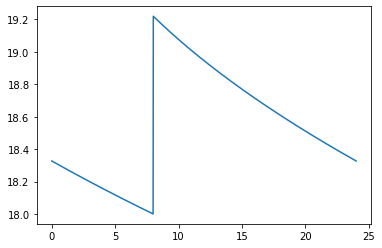

In [172]:

def fit_temp_cesaraccio(min_temp: float = 18,
                        max_temp: float = 24,
                        sunrise: datetime.time = datetime.time(6),
                        sunset: datetime.time = None) -> CubicSpline:
    """
    fits temperature and relative humidiy for a day given the max_temp and min_temp
    also needs sunset and sunrise
    From Cesaraccio et al. 2001 Int.J. Biometeorol. 161-169

    :param min_temp: minimum temperature for the day
    :param max_temp: maximum temperature for the day
    :param sunset: sunset time
    :param sunrise: sunrise time
    :return: spline over 24hr, temperature values
    :rtype: BSpline
    """
    if sunset is None:
        sunset = datetime.datetime.combine(datetime.datetime.min, sunrise) + datetime.timedelta(hours=16)

    print(sunrise, sunset)
    sunrise = sunrise.hour + (sunrise.minute / 60.0) + (sunrise.second / 3600)

    sunset = sunset.hour + (sunset.minute / 60.0) + (sunset.second / 3600)

    assert sunrise < sunset, "this function requires that sunset be after sunrise on the same day"

    alpha = max_temp - min_temp
    to = max_temp - 0.39 * (max_temp - min_temp)
    r = max_temp - to

    hx = sunset - 4.0
    hp = sunrise + 24.0
    b = (min_temp - to) / np.sqrt(hp - sunset)

    def f(st):
        if hx >= st > sunrise:
            t = min_temp + alpha * np.sin((st - sunrise) / (hx - sunrise) * np.pi / 2.0)
        if hx < st < sunset:
            t = to + r * np.sin(np.pi / 2.0 + (st - hx) / 8.0 * np.pi)
        if sunset < st <= hp:
            t = to + b * np.sqrt(st - sunset)
        if st <= sunrise:
            t = to + b * np.sqrt(st + 24.0 - sunset)
        return t

    times = np.linspace(0, 24, 1440)
    temps = np.vectorize(f)(times)

    if temps[0] != temps[-1]:
        temps[-1] = temps[0]
    return CubicSpline(times, temps, bc_type='periodic')

xnew = np.linspace(0, 24, 1440)
spl = fit_temp_cesaraccio(min_temp=18, max_temp=22, sunrise=datetime.time(8))
plt.plot(xnew, spl(xnew))
plt.show()

In [3]:

def fit_temp_sine(min_temp: float = 18,
                  max_temp: float = 24,
                  sunrise: datetime.time = datetime.time(6)) -> CubicSpline:
    """
    does the same as fit_temp_rh, but uses a sine wave rather than the solar days.

    :param min_temp: minimum temperature for the day
    :param max_temp: maximum temperature for the day
    :return:
    """

    sr_off = 5.5 - (sunrise.hour + (sunrise.minute / 60.0))
    f = 2 * np.pi / 24.0

    t_avg = (min_temp + max_temp) / 2.0
    t_amp = (max_temp - min_temp) / 2.0

    times = np.linspace(0, 24, 1440)
    temps = np.vectorize(lambda t: t_avg - t_amp * np.sin((t + sr_off) * f))(times)
    return CubicSpline(times, temps, bc_type='periodic')
    
x = np.linspace(0, 24, 1440)
spl = fit_temp_sine(min_temp=18, max_temp=22, sunrise=datetime.time(6))

plt.plot(x, spl(x))
plt.show()

NameError: name 'CubicSpline' is not defined

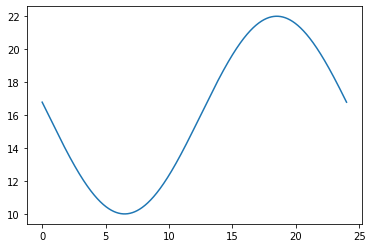

In [6]:
def fit_temp_sine_fast(min_temp: float = 18,
                       max_temp: float = 24,
                       sunrise: datetime.time = datetime.time(6)):
    """
    does the same as fit_temp_rh, but uses a sine wave rather than the solar days.

    :param min_temp: minimum temperature for the day
    :param max_temp: maximum temperature for the day
    :return:
    """

    sr_off = 5.5 - (sunrise.hour + (sunrise.minute / 60.0))
    f = 2 * np.pi / 24.0

    t_avg = (min_temp + max_temp) / 2.0
    t_amp = (max_temp - min_temp) / 2.0

    def w(t):
        return t_avg - t_amp * np.sin((t + sr_off) * f)
    return w
x = np.linspace(0, 24, 1440)
spl = fit_temp_sine_fast(min_temp=10, max_temp=22, sunrise=datetime.time(6))

plt.plot(x, spl(x))
plt.show()

In [ ]:

def relative_humidity(mintemp: float, temp: float) -> float:
    """
    calculates saturated water vapor concentration with a minimum temperature for the day and temperature.
    from FAO Allen, 1985 ??

    :param mintemp: minumum temperature (C) for the day
    :param temp: current temperature (C)
    :return: estimated relative humidity
    :rtype: float
    """

    # # these values shouldnt be under 0
    # eo = max(0.6108 * np.exp((17.27 * temp) / (temp + 273.3)), 0.0)
    #
    # eos = max(0.6108 * np.exp((17.27 * mintemp) / (mintemp + 273.3)), 0.0)
    # # rh shouldnt be over 1.0
    # rh = min(eos / eo, 1.0)
    rh = np.exp((17.625 * mintemp) / (243.04 + mintemp)) / np.exp((17.625 * temp) / (243.04 + temp))
    return rh * 100.0

In [4]:

def clamp(n, minimum=0, maximum=100):
    n = max(n,minimum)
    n = min(n, maximum)
    return n
start = datetime.datetime.now()
start = start.replace(microsecond=0, second=0, minute=0, hour=0)
current = datetime.datetime.now()
current = current.replace(microsecond=0, second=0, minute=0, hour=0)
interval = datetime.timedelta(minutes=1)
section_length = datetime.timedelta(hours=6)
# section for sine wave conditions at 10 minutes
interval = datetime.timedelta(minutes=5)
temp_range = (10, 30)
temp_amp = temp_range[1] - temp_range[0]
humidity_range = (40, 80)
humidity_amp = humidity_range[1] - humidity_range[0]
i = 0
t = []
d = []
deltat = 2
t_avg = 20
deltat = abs(deltat)
mintemp, maxtemp = t_avg - deltat, t_avg + deltat
t_amplitude = (maxtemp - mintemp) / 2.0

sunrise = datetime.time(6)
ft = []
fh = []
while current < start + section_length:
    
    
    
    current += interval
    
    d.append([temp, humidity] + channels)
    t.append(current.timestamp() - start.timestamp())
temp = temp_avg - temp_amp * np.sin((minute + sr_offset) * daily_freq)

06:00:00


NameError: name 'temp' is not defined